# Aluguel de Casas no Brasil
### CRISP-DM Ciclo 1
---

## 0. Preparação

### 0.1 Imports e configurações

In [61]:
import sqlite3
import numpy                as np
import pandas               as pd
import seaborn              as sns
import matplotlib.pyplot    as plt

from scipy                  import stats
from IPython.core.display   import HTML

# Configurando o estilo dos gráficos
sns.set(style = 'whitegrid', palette = 'tab10', color_codes = True)

cor1 = sns.color_palette('tab10')[0]
cor2 = sns.color_palette('tab10')[1]
cor3 = sns.color_palette('tab10')[2]
cor4 = sns.color_palette('tab10')[3]
cor5 = sns.color_palette('tab10')[4]
cor6 = sns.color_palette('tab10')[5]

# Caminho para o diretório do projeto
homepath = '/Users/guttofranca/Repos/brazilian_houses_for_rent/'

# Connect to sqlite database
conn = sqlite3.connect(homepath + 'data/processed/brazilian_houses.db')
data = pd.read_sql_query("SELECT * FROM rentals", conn)


### 0.2 Funções

In [62]:
def jupyter_settings():
    
    """
    Plots pre settings.
    """


    %matplotlib inline
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()
    
jupyter_settings()

sns.set_style('white')

def overview(data):
    """
    Retorna uma visão geral dos dados fornecidos.

    Parâmetros:
    - data: DataFrame contendo os dados a serem analisados.

    Retorna:
    Um dicionário contendo as seguintes informações:
    - 'Número de Linhas': número de linhas do DataFrame.
    - 'Número de Colunas': número de colunas do DataFrame.
    - 'Tipos de Dados': dicionário com os tipos de dados de cada coluna.
    - 'Valores Nulos': dicionário com a contagem de valores nulos em cada coluna.
    - 'Valores Únicos': dicionário com a contagem de valores únicos em cada coluna.
    - 'Valores Duplicados': número de linhas duplicadas no DataFrame.
    """
    
    return {
        'Número de Linhas': data.shape[0],
        'Número de Colunas': data.shape[1],
        'Tipos de Dados': data.dtypes.to_dict(),
        'Valores Nulos': data.isnull().sum().to_dict(),
        'Valores Únicos': data.nunique().to_dict(),
        'Valores Duplicados': data.duplicated().sum()
    }


def describe_extended(data):
    """
    Retorna um DataFrame contendo estatísticas básicas e estendidas de um conjunto de dados.

    Parâmetros:
    data: (pandas.Series) - O conjunto de dados a ser analisado.

    Retorno:
    DataFrame - Um DataFrame contendo as estatísticas básicas (describe) e estendidas (var, skewness, kurtosis) do conjunto de dados.
    """
    # Use o método describe() para obter as estatísticas básicas
    desc = data.describe()
    
    # Calcule a skewness e a kurtosis para cada coluna
    var = data.var()
    skewness = data.apply(stats.skew)
    kurt = data.apply(stats.kurtosis)

    
    # Crie um novo DataFrame para armazenar as estatísticas estendidas
    extended_stats = pd.DataFrame({'var': var, 'skew': skewness, 'kurtosis': kurt})
    
    # Concatene o DataFrame de descrição básica com o DataFrame de estatísticas estendidas
    return pd.concat([desc, extended_stats.transpose()]).apply(lambda s: s.apply('{0:.3f}'.format))


def identify_outliers(dataframe, variables):
    """
    Identifica os 5 outliers mais extremos para cada variável especificada em um dataframe.

    dataframe(pandas.Series): DataFrame para análise.
    variables(List): Lista de variáveis (colunas) para identificar outliers.
    
    Retorna:  Dicionário de DataFrames, cada um contendo os 5 outliers mais extremos para cada variável.
    """
    outlier_dataframes = {}

    # Calcula os limiares de outliers para cada variável
    for var in variables:
        Q1 = dataframe[var].quantile(0.25)
        Q3 = dataframe[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtra os outliers
        outliers = dataframe[(dataframe[var] < lower_bound) | (dataframe[var] > upper_bound)]

        # Cria um dataframe com os 5 outliers mais extremos
        outlier_dataframes[var] = pd.DataFrame(outliers.nlargest(5, var), columns=['id', var])

    return outlier_dataframes


## Descrição dos dados

---
- **id**: Identificador único dos imóveis.
- **city**: Código da cidade onde o imóvel está localizado.
- **area**: Área do imóvel em metros quadrados.
- **rooms**: Número de quartos.
- **bathroom**: Número de banheiros.
- **parking spaces**: Número de vagas de estacionamento.
- **floor**: Andar do imóvel.
- **animal**: Permissão para animais de estimação (1 para sim, 0 para não).
- **furniture**: Mobiliado (1 para sim, 0 para não).
- **hoa**: Valor do condomínio.
- **rent amount**: Valor do aluguel.
- **property tax**: Valor do IPTU (Imposto Predial e Territorial Urbano).
- **fire insurance**: Valor do seguro contra incêndio.
- **total**: Valor total do aluguel, incluindo todas as taxas.

---


In [63]:
overview(data)

{'Número de Linhas': 6080,
 'Número de Colunas': 14,
 'Tipos de Dados': {'id': dtype('int64'),
  'city': dtype('int64'),
  'area': dtype('int64'),
  'rooms': dtype('int64'),
  'bathroom': dtype('int64'),
  'parking spaces': dtype('int64'),
  'floor': dtype('int64'),
  'animal': dtype('int64'),
  'furniture': dtype('int64'),
  'hoa': dtype('int64'),
  'rent amount': dtype('int64'),
  'property tax': dtype('int64'),
  'fire insurance': dtype('int64'),
  'total': dtype('int64')},
 'Valores Nulos': {'id': 0,
  'city': 0,
  'area': 0,
  'rooms': 0,
  'bathroom': 0,
  'parking spaces': 0,
  'floor': 0,
  'animal': 0,
  'furniture': 0,
  'hoa': 0,
  'rent amount': 0,
  'property tax': 0,
  'fire insurance': 0,
  'total': 0},
 'Valores Únicos': {'id': 6080,
  'city': 2,
  'area': 435,
  'rooms': 9,
  'bathroom': 10,
  'parking spaces': 10,
  'floor': 37,
  'animal': 2,
  'furniture': 2,
  'hoa': 1290,
  'rent amount': 1032,
  'property tax': 1035,
  'fire insurance': 190,
  'total': 4069},
 'V

In [64]:
# Análise estatística
describe_extended(data).T

,count,mean,std,min,25%,50%,75%,max,var,skew,kurtosis
id,6080.000,3039.500,1755.289,0.000,1519.750,3039.500,4559.250,6079.000,3081040.000,0.000,-1.200
city,6080.000,0.863,0.344,0.000,1.000,1.000,1.000,1.000,0.118,-2.115,2.475
area,6080.000,151.144,375.559,10.000,58.000,100.000,200.000,24606.000,141044.927,51.693,3162.252
rooms,6080.000,2.493,1.130,1.000,2.000,3.000,3.000,10.000,1.276,0.528,0.761
bathroom,6080.000,2.342,1.439,1.000,1.000,2.000,3.000,10.000,2.070,1.070,0.772
parking spaces,6080.000,1.756,1.612,0.000,1.000,1.000,2.000,12.000,2.598,1.434,2.682
floor,6080.000,5.672,6.169,0.000,0.000,4.000,9.000,99.000,38.056,2.117,15.488
animal,6080.000,0.767,0.423,0.000,1.000,1.000,1.000,1.000,0.179,-1.266,-0.397
furniture,6080.000,0.260,0.439,0.000,0.000,0.000,1.000,1.000,0.193,1.093,-0.805
hoa,6080.000,1088.426,3981.358,0.000,24.500,650.000,1436.000,220000.000,15851208.553,47.922,2525.963


## Análise Exploratória de Dados (EDA)

### Visão Geral dos Dados:
- Número de Linhas: 6080
- Número de Colunas: 14
- Tipos de Dados: Todos são inteiros
- Valores Nulos: Não há valores nulos em nenhuma coluna.
- Valores Únicos: Existem 2 cidades, 435 áreas de imóveis diferentes sendo nenhum duplicado
- Valores Duplicados: 0

### Análise Estatística Descritiva:
- Área: Varia de 10 a 24.606 m², com média de 151,14 m².
- Quartos: A maioria dos imóveis tem entre 1 e 3 quartos.
- Banheiros: Em média, os imóveis possuem 2,34 banheiros.
- Vagas de Estacionamento: Média de 1,76 vagas por imóvel.
- Andar: Varia de 0 (possivelmente térreo) a 99, com média de 5,67.
- Animais de Estimação: A maioria dos imóveis permite animais (76,74%).
- Mobília: 26,02% dos imóveis são mobiliados.
- Custos Financeiros: O valor do aluguel varia significativamente, com uma média de R$ 4.395,84.

### Outliers

In [65]:
variables = ['rent amount', 'area', 'hoa', 'property tax']
outliers_df = identify_outliers(data, variables)


In [66]:
outliers_df['area']

,id,area
4178,4178,24606
5494,5494,12732
3983,3983,1600
5178,5178,1000
1533,1533,999


In [67]:
outliers_df['hoa']

,id,hoa
1269,1269,220000
3303,3303,200000
4438,4438,14130
832,832,10000
5752,5752,9900


In [68]:
outliers_df['property tax']

,id,property tax
5627,5627,366300
2611,2611,313700
5025,5025,10830
3694,3694,9500
4356,4356,9500


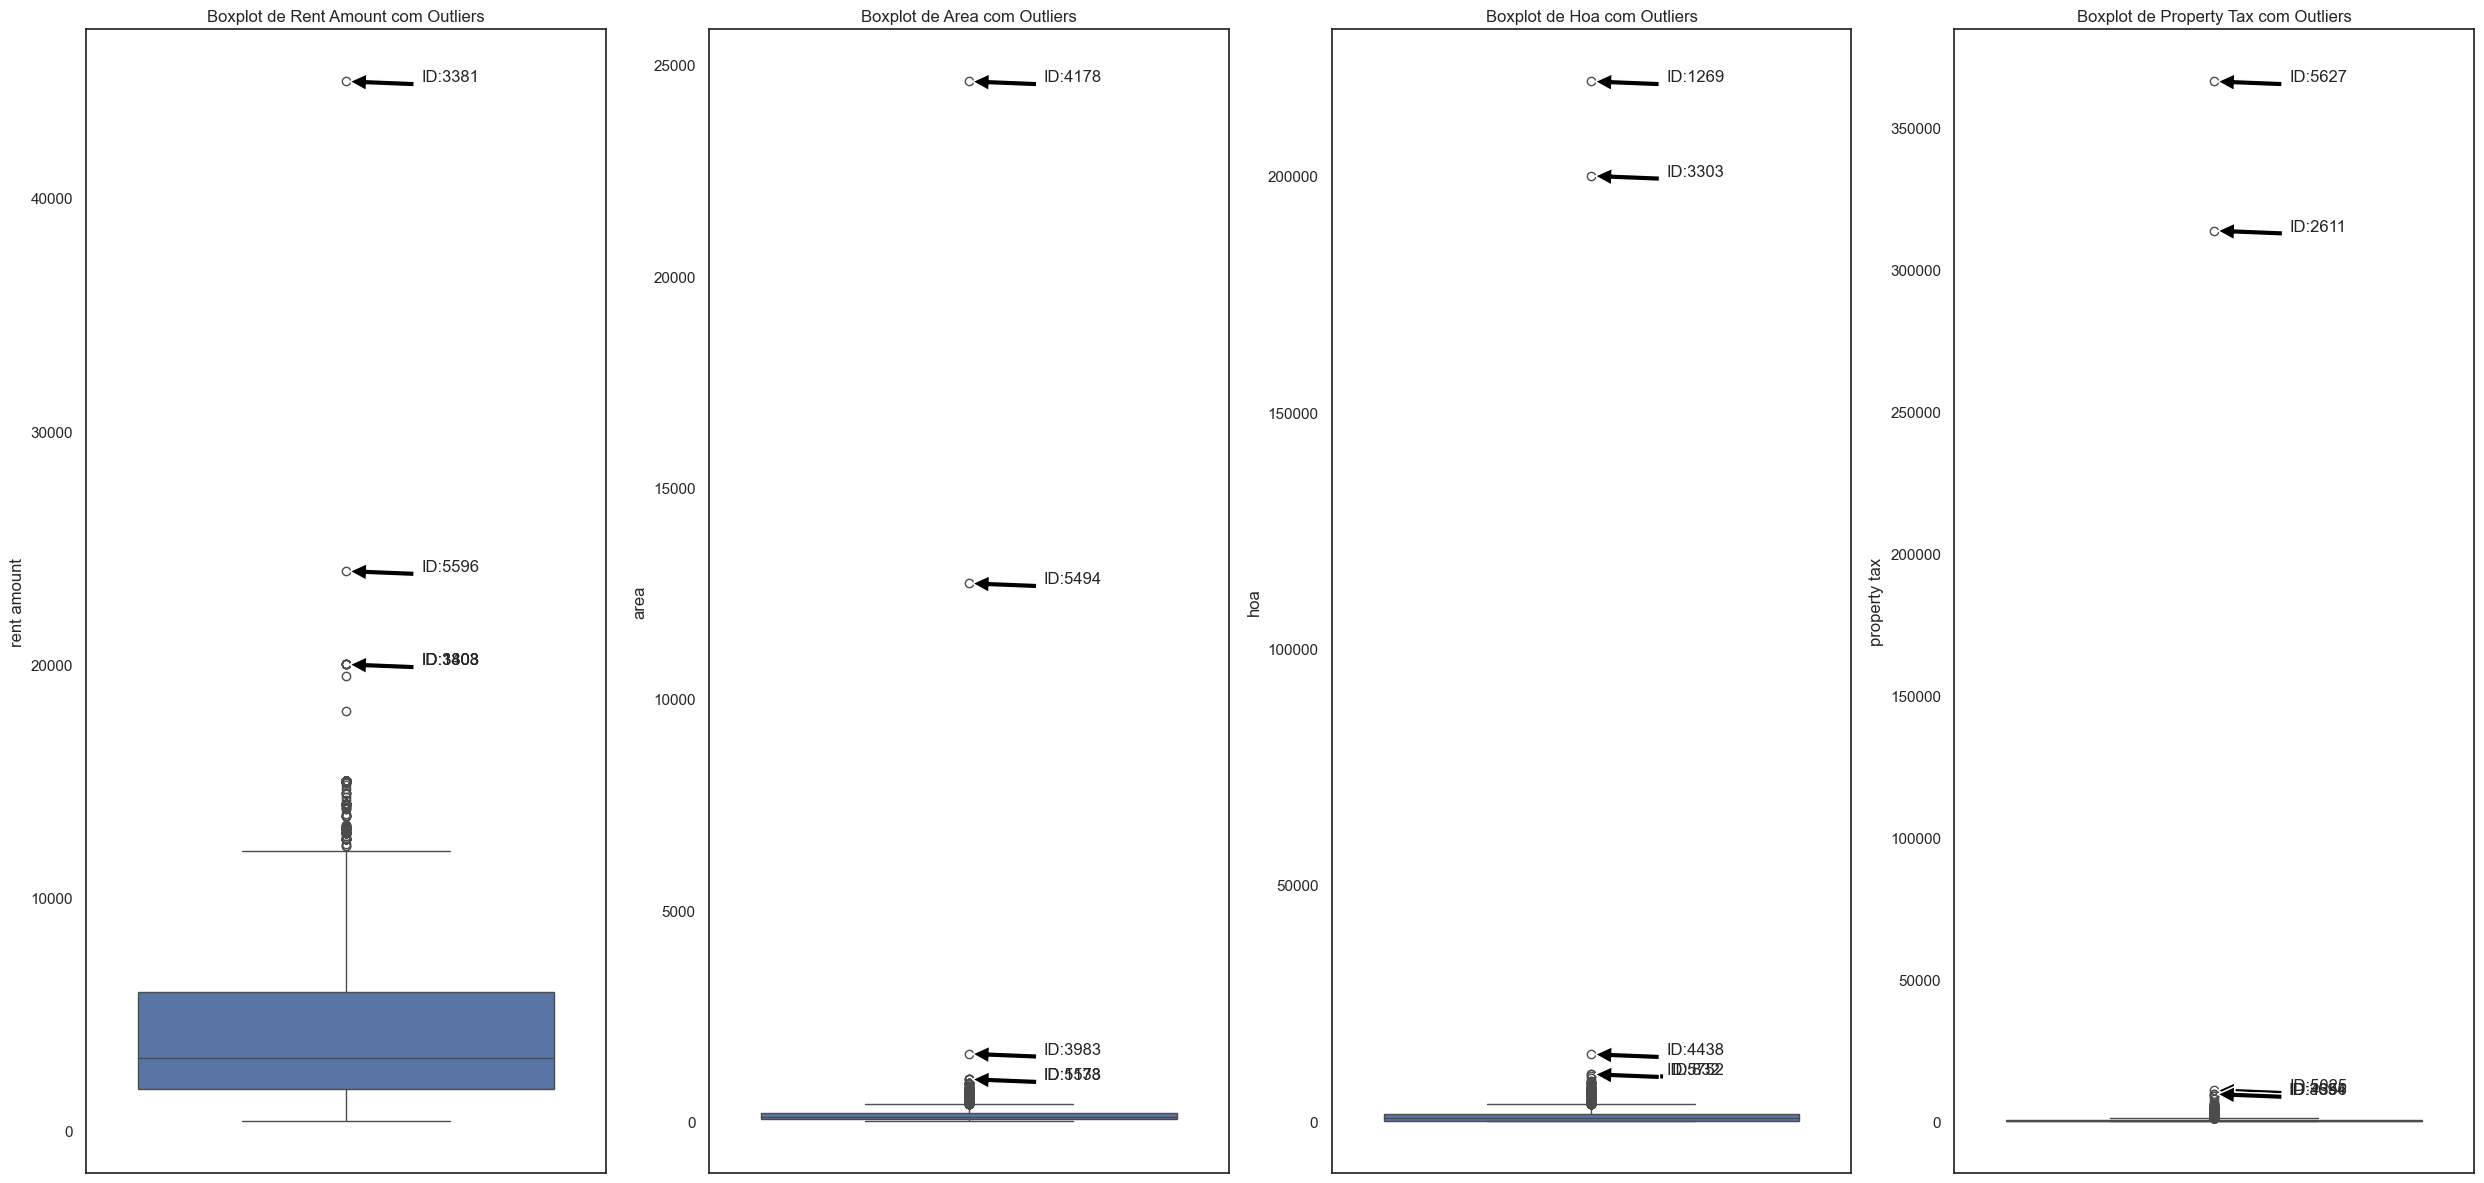

In [69]:
# Configurando o tamanho dos gráficos
plt.figure()

# Criando boxplots e anotando os top 5 outliers para cada variável
for i, var in enumerate(variables, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y = data[var])
    plt.title(f'Boxplot de {var.title()} com Outliers')

    # Anotando os top 5 outliers
    for index, row in outliers_df[var].iterrows():
        plt.annotate(f'ID:{row["id"]}', xy=(0, row[var]), xytext=(0.2, row[var]),
                     arrowprops=dict(facecolor='black', shrink=0.05), ha='center')

plt.tight_layout()
plt.savefig(homepath + 'reports/figures/boxplot_outliers.png')
plt.show()

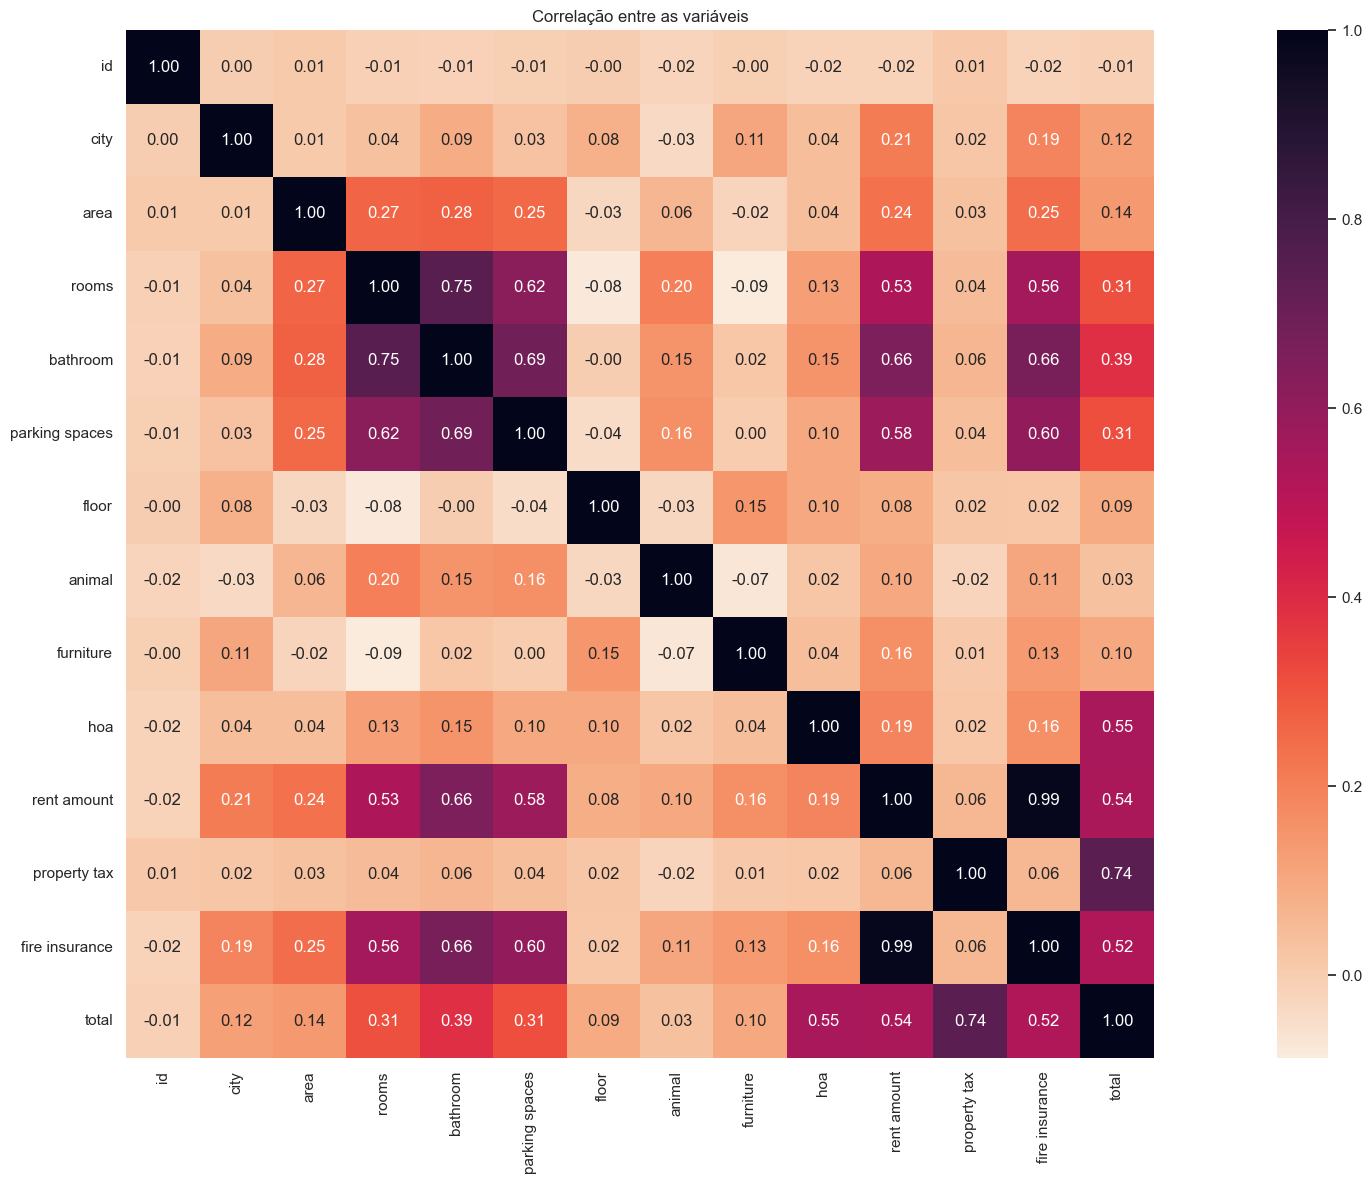

In [70]:
# Criando um heatmap para verificar a correlação entre as variáveis
corr = data.corr()
sns.heatmap(corr, cmap = 'rocket_r', fmt = '.2f', square = True, linecolor = 'white', annot = True)

plt.title('Correlação entre as variáveis')
plt.tight_layout()
plt.savefig(homepath + 'reports/figures/correlation.png')



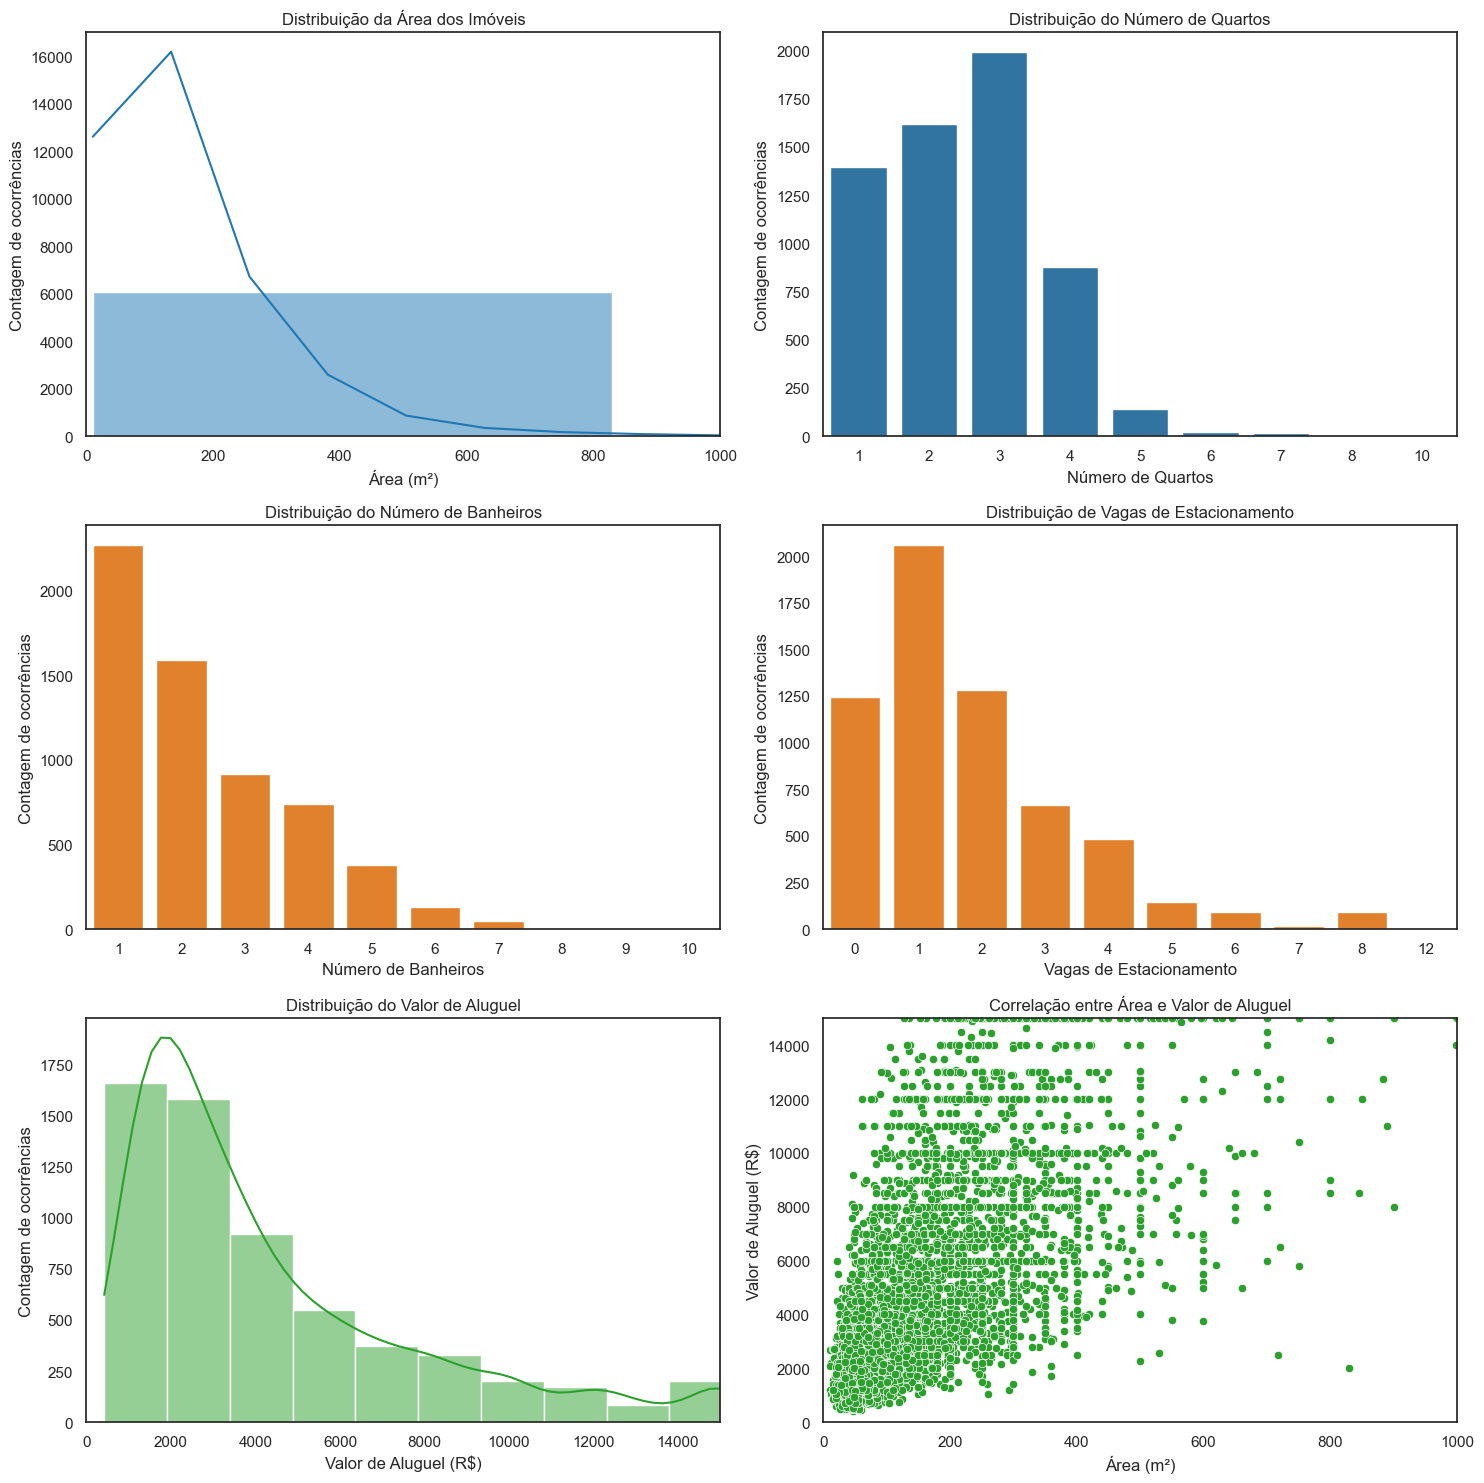

<Figure size 2500x1200 with 0 Axes>

In [71]:
# Criando um conjunto de figuras para várias análises
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Distribuição de Área
sns.histplot(data['area'], bins=30, ax=axes[0, 0], kde=True, color = cor1)
axes[0, 0].set_title('Distribuição da Área dos Imóveis')
axes[0, 0].set_xlim(0, 1000) # Limitando
axes[0, 0].set_xlabel('Área (m²)')
axes[0, 0].set_ylabel('Contagem de ocorrências')

# Distribuição de Quartos
sns.countplot(x='rooms', data=data, ax=axes[0, 1], color = cor1)
axes[0, 1].set_title('Distribuição do Número de Quartos')
axes[0, 1].set_xlabel('Número de Quartos')
axes[0, 1].set_ylabel('Contagem de ocorrências')

# Distribuição de Banheiros
sns.countplot(x='bathroom', data=data, ax=axes[1, 0], color = cor2)
axes[1, 0].set_title('Distribuição do Número de Banheiros')
axes[1, 0].set_xlabel('Número de Banheiros')
axes[1, 0].set_ylabel('Contagem de ocorrências')

# Distribuição de Vagas de Estacionamento
sns.countplot(x='parking spaces', data=data, ax=axes[1, 1], color = cor2)
axes[1, 1].set_title('Distribuição de Vagas de Estacionamento')
axes[1, 1].set_xlabel('Vagas de Estacionamento')
axes[1, 1].set_ylabel('Contagem de ocorrências')

# Distribuição do Valor de Aluguel
sns.histplot(data['rent amount'], bins=30, ax=axes[2, 0], kde=True, color = cor3)
axes[2, 0].set_title('Distribuição do Valor de Aluguel')
axes[2, 0].set_xlim(0, 15000) # Limitando 
axes[2, 0].set_xlabel('Valor de Aluguel (R$)')
axes[2, 0].set_ylabel('Contagem de ocorrências')

# Correlação entre Área e Valor de Aluguel
sns.scatterplot(x='area', y='rent amount', data=data, ax=axes[2, 1], color = cor3)
axes[2, 1].set_title('Correlação entre Área e Valor de Aluguel')
axes[2, 1].set_xlim(0, 1000) # Limitando
axes[2, 1].set_ylim(0, 15000)
axes[2, 1].set_xlabel('Área (m²)')
axes[2, 1].set_ylabel('Valor de Aluguel (R$)')

plt.tight_layout()
plt.show()
plt.savefig(homepath + 'reports/figures/distribuições.png')